## BOOSTING

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Nesse trabalho implementaremos um processo de Boosting assumindo classificação binária com atributos categóricos.

O método Boosting tem o objetivo de criar um classificador forte através da junção de classificadores fracos (que geralmente são decision stumps). Enquando classificadores fortes são aqueles que retornam resultados próximos de 1 ou 0, os classificadores fracos são aqueles que retornam valores com certa incerteza, geralmente valores próximos de 0.5. Juntando vários classificadores fracos, o modelo evita overfitting por utilizar outros modelos muito simples que não se ajustam excessivamente aos dados do treino. Além disso, durante o treinamento os modelos posteriores são ajustados para corrigir erros que foram cometidos nos modelos anteriores, que também auxilia na redução do overfitting.

### 1. Estração de Dados

Primeiramente vamos utilizar a base de dados tic tac toe endgame disponível em https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame

A base é composta por 9 colunas que representam as posições em um tabuleiro de jogo da velha. Cada coluna pode assumir o valor x e o (representando as marcações dos jogadores), ou b (representando que nenhum jogador marcou essa posição).

E a saída na base é representada por 'positive' (representando a vitória de x) ou 'negative' (representando que x não ganhou).

In [3]:
df = pd.read_csv('tic-tac-toe.data', header=None)
df

,0,1,2,3,4,5,6,7,8,9
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive
...,...,...,...,...,...,...,...,...,...,...
953,o,x,x,x,o,o,o,x,x,negative
954,o,x,o,x,x,o,x,o,x,negative
955,o,x,o,x,o,x,x,o,x,negative
956,o,x,o,o,x,x,x,o,x,negative


Vamos alterar a base para trabalhar com a saída sendo -1 para negativo e 1 para positivo.

In [4]:
df[9] = df[9].map({"positive" : 1, "negative" : -1})
df

,0,1,2,3,4,5,6,7,8,9
0,x,x,x,x,o,o,x,o,o,1
1,x,x,x,x,o,o,o,x,o,1
2,x,x,x,x,o,o,o,o,x,1
3,x,x,x,x,o,o,o,b,b,1
4,x,x,x,x,o,o,b,o,b,1
...,...,...,...,...,...,...,...,...,...,...
953,o,x,x,x,o,o,o,x,x,-1
954,o,x,o,x,x,o,x,o,x,-1
955,o,x,o,x,o,x,x,o,x,-1
956,o,x,o,o,x,x,x,o,x,-1


### 2. Implementação do Boosting

O algoritmo do Boosting tem um processo iterativo representado por:

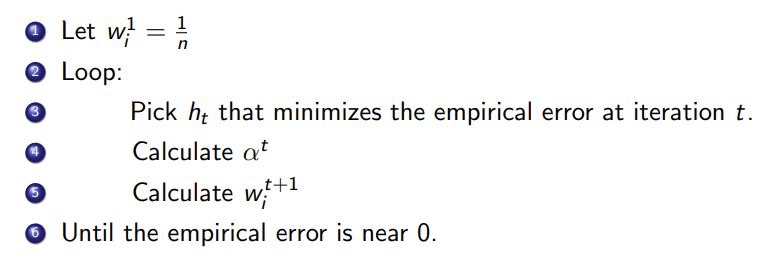

    Primeiramente definimos o peso de todos os dados do treino como 1/n.

    Enquanto o erro empírico não for próximo de 0 ou para um número específico de iterações iremos:

        Escolher o stump com o menor erro atualmente.
        Calcular o alpha da rodada.
        Atualizar os pesos com o stump e o alpha


Fórmula para cálculo de alpha e novos pesos:

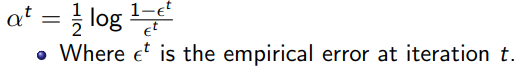

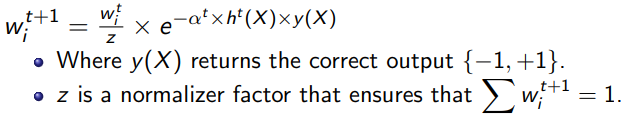

Vamos criar uma classe para a implementação do algoritmo de boosting do problema.

Para criação dos stumps iremos utilizar decisões simples que retornam a predição com base em um único atributo. Como existem 9 atributos que podem assumir 3 valores diferentes e resultar em 2 saídas, temos um total de 9 x 3 x 2 = 54 stumps. Além destes, existem 2 outros stumps para serem testados, um que diz que a saída é sempre positiva, e um que diz que a saída é sempre negativa. No total temos então 56 stumps possíveis.

In [50]:
class Boosting:

    # O construtor recebe o dataframe a ser utilizado e as iterações a serem feitas para escolha dos stumps
    def __init__(self, df, rounds):

        # Número de iterações
        self.rounds = rounds

        # Dataframe
        self.df = df

        # Conjunto de pesos (inicialmente balanceado)
        self.w = np.array(self.df.shape[0] * [1/self.df.shape[0]])

        # Função auxiliar para criar funções dos stumps de atributos
        self.h1 = lambda i : lambda k: lambda x :  1 if x[i] == k else -1
        self.h2 = lambda i : lambda k: lambda x : -1 if x[i] == k else 1

        # Lista de stumps selecionados
        self.hs = []

        # Lista de alphas
        self.alphas = []

        # Lista de erros
        self.errors = []

        self.create_stumps()

        

    def get_df(self):
        return self.df

    # Cria todos os stumps possíveis (um stump é a verificação do valor de uma coluna do dataframe com a saída)
    def create_stumps(self):

        # Quantidade de possiveis stumps
        self.stumps = {}

        # Itera pelas colunas
        for i in range(9):

            # listas de missclassified dos stumps negativos
            stump0miss = [[],[],[]]

            # listas de missclassified dos stumps negativos
            stump1miss = [[],[],[]]

            # Para cada linha irá verificar se o stump acerta ou erra e adiciona na lista correspondente (na lista do que errou, ou seja, a lista de missclassified)
            for j in range(self.df.shape[0]):
                simbolos = ["x","o","b"]

                # itera pelos simbolos
                for k in range(3):

                    # itera as previsoes
                    for p in [-1, 1]:

                        if self.df.iloc[j,i] == simbolos[k] and self.df.iloc[j,9] != p:
                            if p == 1:
                                stump1miss[k].append(j)
                            else:
                                stump0miss[k].append(j)

                        elif self.df.iloc[j,i] != simbolos[k] and self.df.iloc[j,9] == p:
                            if p == 1:
                                stump1miss[k].append(j)
                            else:
                                stump0miss[k].append(j)
            
            # Será construido um dicionário contendo todos os stumps e a sua lista de missclassified (atributo,simbolo,(afirmacao ou negacao))
            self.stumps["{0}x1".format(i)] = stump1miss[0]
            self.stumps["{0}o1".format(i)] = stump1miss[1]
            self.stumps["{0}b1".format(i)] = stump1miss[2]
            self.stumps["{0}x0".format(i)] = stump0miss[0]
            self.stumps["{0}o0".format(i)] = stump0miss[1]
            self.stumps["{0}b0".format(i)] = stump0miss[2]
        
        # listas de missclassified dos stumps All Positive e All Negative
        stumpTmiss = []
        stumpFmiss = []

        # verifica os casos em que esses stumps erram e adiciona na lista de missclassified correspondente
        for j in range(self.df.shape[0]):
            if self.df.iloc[j,9] == 1:
                stumpFmiss.append(j)
            else:
                stumpTmiss.append(j)
        
        # adiciona ao dicionário
        self.stumps["9t1"] = stumpTmiss
        self.stumps["9f0"] = stumpFmiss


    def get_stumps(self):
        return self.stumps

    # Escolhe o stump que apresenta menor erro
    def get_better_stump(self):
        error = 1
        name = ""

        # Iterando pela lista de stumps iremos escolher o que apresenta menor erro
        for n, stump in self.stumps.items():
            e = 0

            # O erro se dá pela soma dos pesos atribuidos aos casos em que o stump errou
            for i in stump:
                e += self.w[i]
            if e < error:
                name = n
                error = e
        return name, error
    
    # Calculo de alphat
    def alphat(self, error):
        return np.log((1 - error)/error) / 2
    
    # Calculo dos novos pesos w(t+1)
    def wtp1(self, alphat, ht):
            for i in range(len(self.w)):
                self.w[i] = np.float64(self.w[i]) * np.exp((-alphat)*(ht(self.df.iloc[i]))*(self.df.iloc[i,9]))

            # normaliza os pesos de forma a soma de todos ser igual a 1
            self.w = np.divide(self.w, self.w.sum())

    def get_w(self):
        return self.w
    
    # Criação da função H() que utiliza os hts e os alphats
    # Iteração do boosting por 'rounds' iterações
    def fit(self):
        for i in range(self.rounds):

            # retorna os dados do melhor stump
            name, error = self.get_better_stump()
            feature = int(name[0])
            simbolo = name[1]
            signal = int(name[2])

            # funcao do stump para previsao positiva
            ht = self.h1(feature)(simbolo)

            # se a previsao for negativa
            if signal == 0:
                ht = self.h2(feature)(simbolo)

            # se for o stump All Positive
            if simbolo == "t":
                ht = lambda i : 1

            # se for o stump All Negative
            if simbolo == "f":
                ht = lambda i : -1

            self.hs.append(ht)

            # calcula o alpha da rodada
            alphat = self.alphat(error)
            self.alphas.append(alphat)

            self.errors.append(error)

            # atualiza os erros
            self.wtp1(alphat, ht)

    # Função que testa a saída do algoritmo gerado com uma entrada 'values'
    def test(self, values):
        sum = 0
        for i in range(self.rounds):
            sum += self.alphas[i] * self.hs[i](values)
        return np.sign(sum)
    
    def get_h(self):
        return self.alphas, self.hs
    
    def get_errors(self):
        return self.errors
    

### 3. Análise do Classificador Criado

Realizaremos a avaliação do modelo com a validação cruzada com 5 partições. A medida de eficácia a ser considerada é a taxa de erro simples.

Esse método consiste em dividir o dado em 5 partições e realizar 5 modelos a partir delas. Em cada modelo iremos utilizar 4 partições para treino e 1 partição para teste, de forma que em cada modelo uma partição diferente é utilizada para o teste. Ao final, fazemos a média dos erros dos testes de cada modelo e obtemos o erro de validação cruzada com 5 partições.

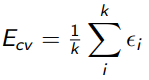

O erro de validação cruzada é interessante de ser utilizado porque ele é uma boa aproximação do erro esperado, principalmente a medida que o número de partições aumenta.

In [6]:
# Função para o cálculo do erro de validação cruzada de k partições
def boosting_crossvalk(df, rounds, k):

    # mistura os dados
    dfshuffle = df.sample(frac=1).reset_index(drop=True)

    part = []

    # cria k partições dos dados
    for i in range(k):
        part.append(dfshuffle.iloc[int((i) * dfshuffle.shape[0]/k) : int((i + 1) * dfshuffle.shape[0]/k)])

    ecrossval = 0

    # gera k modelos e seleciona as partições de treino e teste para serem utilizadas em cada modelo
    for i in range(k):
        treino = pd.DataFrame()
        teste = part[i]
        for j in range(k):
            if j != i:
                treino = pd.concat((treino, part[j]), axis=0)
        if k == 1:
            treino = teste
        model = Boosting(treino, rounds)
        model.fit()

        dft = teste[[0,1,2,3,4,5,6,7,8]]
        pred = []

        # faz a predição do modelo criado com os dados de teste
        for i in range(dft.shape[0]):
            values = []
            for j in range(dft.shape[1]):
                values.append(dft.iloc[i,j])
            pred.append(model.test(values))

        s = 0

        # compara a saída da predição com a saída real e conta os acertos
        for i in range(len(pred)):
            if teste.iloc[i,9] == pred[i]:
                s+=1
        
        # soma o erro do modelo ao erro de validacao cruzada
        # o erro do modelo no teste é 1 - proporção de acertos
        ecrossval += 1.0 - s/len(pred)

    # retorna a média
    return ecrossval/k

Variando as iterações iremos computar um gráfico que mostra o erro de cross validation de 5 partições conforme o número de iterações do algoritmo aumenta.

In [7]:
errors = []
rounds = 300
for i in range(rounds):
    errors.append(boosting_crossvalk(df, i, 5))

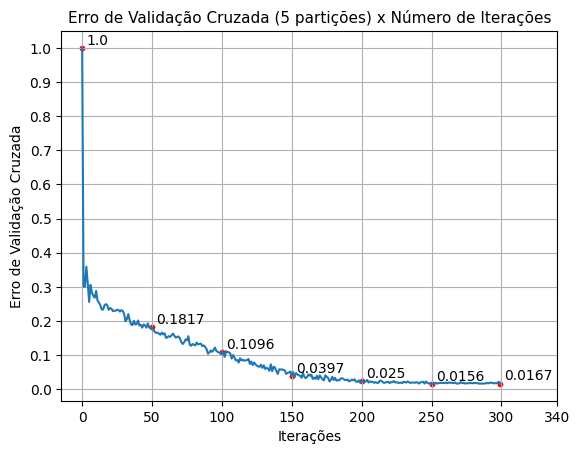

In [49]:
fig, ax = plt.subplots()
ax.plot(range(0,rounds), errors)

for i in range(0,len(errors),50):
    ax.text(range(0,rounds)[i]+3, errors[i]+0.01, round(errors[i], 4))
    ax.scatter(range(0,rounds)[i], errors[i], color='red', marker='o', s=10)
ax.text(299+3, errors[299]+0.01, round(errors[299], 4))
ax.scatter(299, errors[299], color='red', marker='o', s=10)

plt.title("Erro de Validação Cruzada (5 partições) x Número de Iterações", fontsize=11)
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.xticks([0,50,100,150,200,250,300,340])
plt.xlabel("Iterações")
plt.ylabel("Erro de Validação Cruzada")

plt.grid()
plt.show()

Podemos observar a partir do gráfico que o erro de validação cruzada com 5 partições diminui a medida que realizamos mais iterações no algoritmo. Esse é o resultado esperado já que nos algoritmos de boosting quanto mais stumps são utilizados a tendência é a diminuição do erro (mas deve haver um limite para que o modelo não se ajuste em excesso aos dados do treino). Isso acontece porque quando adicionamos novos stumps estamos fazendo com que o algoritmo tente corrigir os exemplos que ainda não estão gerando a saída correta, que são os exemplos que estarão com o maior peso para escolha do stump.

### 4. Outra Análise

Além disso, podemos observar a influência e o erro de cada stump no algoritmo. Para isso, será feito um treinamento do algoritmo com todos os dados, somente para analisar esses valores a medida que novos stumps são adicionados.

In [51]:
model = Boosting(df, 300)
model.fit()

In [52]:
alphas, hs = model.get_h()
errors = model.get_errors()

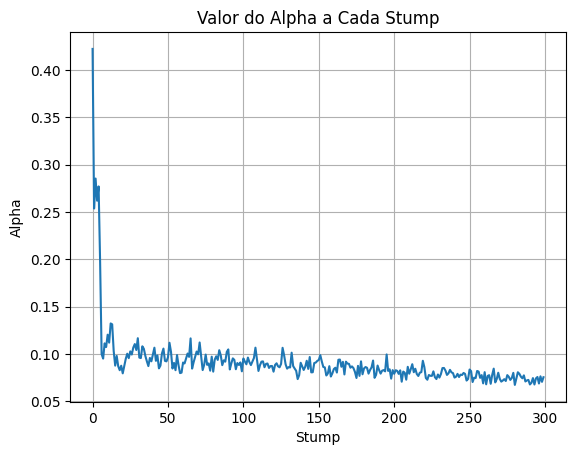

In [56]:
plt.plot(alphas)

plt.title("Valor do Alpha a Cada Stump")
plt.xlabel("Stump")
plt.ylabel("Alpha")
plt.grid()
plt.show()

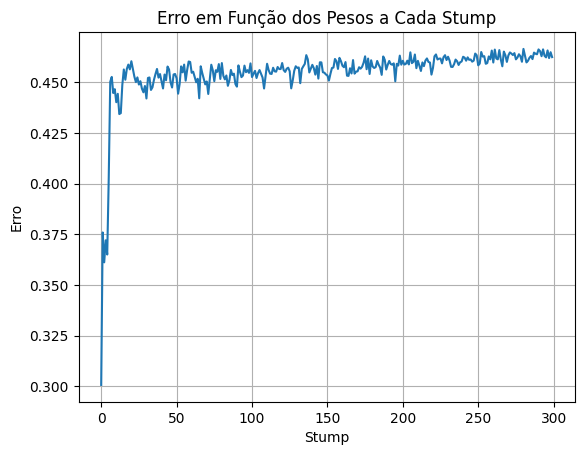

In [58]:
plt.plot(errors)

plt.title("Erro em Função dos Pesos a Cada Stump")
plt.xlabel("Stump")
plt.ylabel("Erro")
plt.grid()
plt.show()